# Set Environment & Libraries

In [73]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import os       # operating system, eg. file path...
# import warnings

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
import seaborn as sns
sns.set_style('whitegrid')
# from plotly import tools
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.figure_factory as ff

# Modelling
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA


# Feature engineering
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Model support functions
import math
from numpy.random import normal, seed
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#  Load Data

In [74]:
# parse_date:
# Function to use for converting a sequence of string columns to an array of datetime instances
df = pd.read_csv('/Users/songyarong/Workspace/5. Project/8. Time Series/co2.csv', parse_dates=['date'], index_col='date')
df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


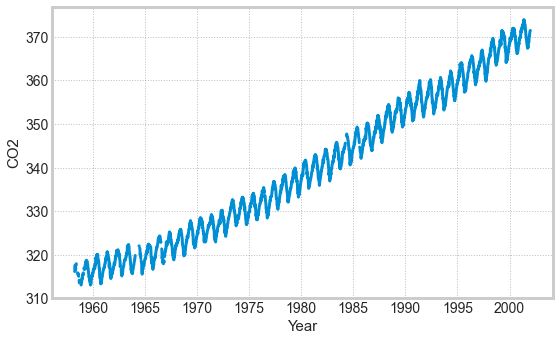

In [75]:
fig,ax = plt.subplots(nrows=1, figsize=(8,5))
ax.plot(df, linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('CO2')
ax.grid(color='gray', alpha=0.5, linestyle='dotted')
# ax.grid(False)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

#  Data Exploration

## Understand the Raw Dataset

In [76]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


## Missing value

In [77]:
# Check missing value
df.isnull().sum()

co2    59
dtype: int64

In [78]:
# Resample Time-Series data by Month and get the Mean
# 大气二氧化碳数据是以周为单位的，时间距离太短，可使用每月平均值
y = df['co2'].resample('MS').mean()

<AxesSubplot:xlabel='date'>

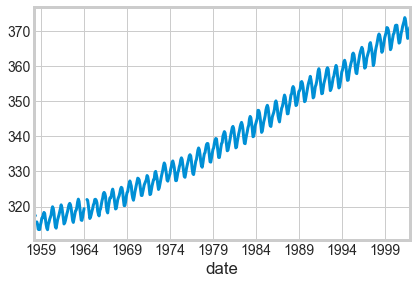

In [79]:
y.plot(linewidth=3)

In [80]:
y.isnull().sum()

5

In [81]:
# Data after resampling by month
y.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [82]:
type(y)

pandas.core.series.Series

In [83]:
y.describe()

count    521.000000
mean     339.822665
std       17.068711
min      313.400000
25%      324.125000
50%      337.950000
75%      354.675000
max      373.800000
Name: co2, dtype: float64

Text(0.5, 1.0, 'CO2 Variation Over Years')

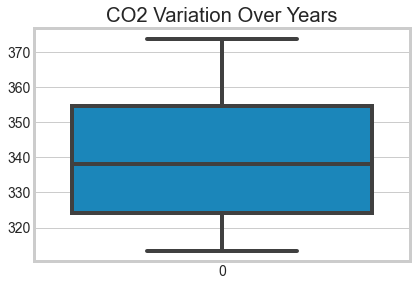

In [84]:
sns.boxplot(data=y)
plt.title('CO2 Variation Over Years')

In [85]:
y.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01',
               '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01',
               '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', name='date', length=526, freq='MS')

<AxesSubplot:xlabel='date'>

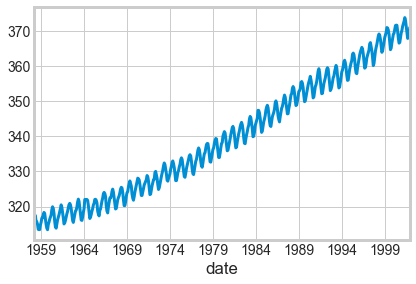

In [86]:
y = y.fillna(method='bfill')
y.plot(linewidth=3)

In [87]:
y.isnull().sum()

0

## De-trending

### Trend: rolling mean and std

In [88]:
rollingmean = y.rolling(window=12).mean()
rollingstd = y.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean')

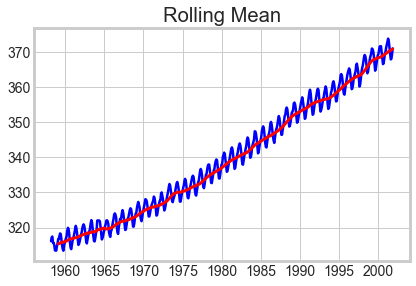

In [89]:
plt.plot(y, color='blue', linewidth=2.5, label='Original')
plt.plot(rollingmean, color='red', linewidth=3, label='Rolling Mean')
plt.title('Rolling Mean')

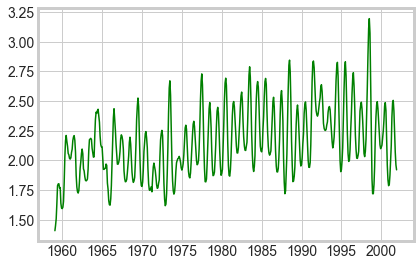

In [90]:
plt.plot(rollingstd, color='green', linewidth=1.5, label='Rolling Std')

### Seasonal cycle

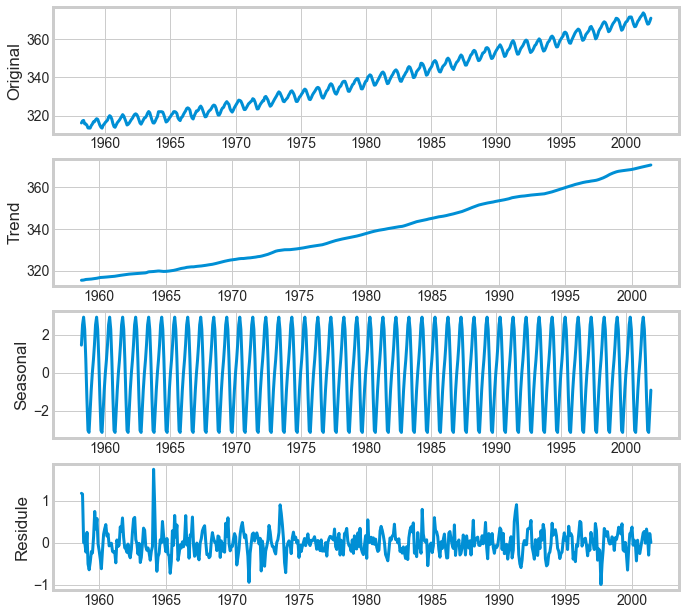

In [91]:
# decompose: 1) Trend; 2) Seasonal; 3) Residual
deco = sm.tsa.seasonal_decompose(y, model='additive')
fig,ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(y, linewidth=3)
ax[0].set_ylabel("Original")
ax[1].plot(deco.trend, linewidth=3)
ax[1].set_ylabel("Trend")
ax[2].plot(deco.seasonal,linewidth=3)
ax[2].set_ylabel("Seasonal")
ax[3].plot(deco.resid,linewidth=3)
ax[3].set_ylabel("Residule")
# deco.plot()
plt.show()

In [92]:
# Explore the residule
deco.resid.describe()

count    514.000000
mean       0.002790
std        0.298683
min       -0.997063
25%       -0.195065
50%       -0.008551
75%        0.166299
max        1.745334
Name: resid, dtype: float64

In [93]:
deco.resid.isnull().sum()

12

In [94]:
CO2residual = deco.resid
CO2residual = CO2residual.fillna(method='bfill')  # 只进行一次可能不能完全fillna
CO2residual = CO2residual.fillna(method='ffill')  # both 'bfill' and 'ffill'

In [95]:
CO2residual.describe()

count    526.000000
mean       0.016137
std        0.320423
min       -0.997063
25%       -0.192372
50%       -0.000486
75%        0.169395
max        1.745334
Name: resid, dtype: float64

In [96]:
CO2residual.isnull().sum()

0

<AxesSubplot:xlabel='date'>

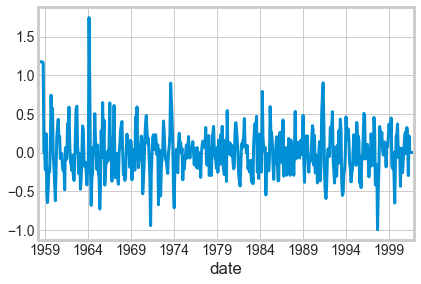

In [97]:
CO2residual.plot(linewidth=3)

# Modelling

## Check if the residual is stationary

In [98]:
# Calculate the ADF of residual
ADFresult = adfuller(CO2residual)

In [99]:
ADFresult

(-12.181866290607799,
 1.3458236912281968e-22,
 9,
 516,
 {'1%': -3.443086684769254,
  '5%': -2.867157550015396,
  '10%': -2.5697619453458325},
 5.109878354839793)

In [100]:
print('ADF statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical values:')
for key, value in ADFresult[4].items():
    print('\t%s; %.3f' % (key, value))

ADF statistic: -12.181866
p-value: 0.000000
Critical values:
	1%; -3.443
	5%; -2.867
	10%; -2.570


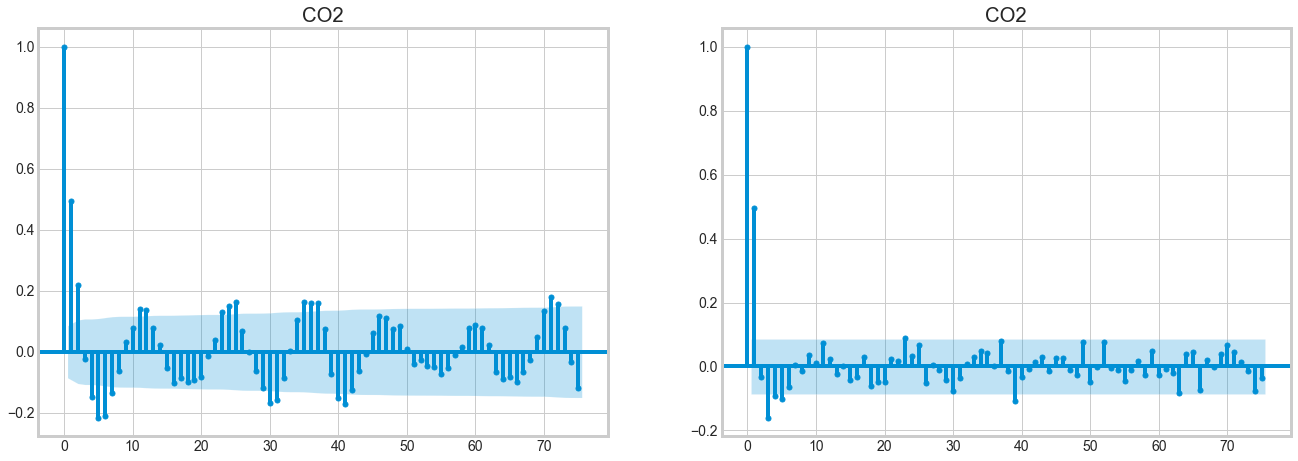

In [101]:
fig,ax = plt.subplots(1, 2, figsize=(20,7))
plot_acf(CO2residual,lags=75,title="CO2",ax=ax[0])
plot_pacf(CO2residual,lags=75,title="CO2",ax=ax[1])
plt.show()

# ACF: tail off
# PACF: cut off
# AR model

## Original data

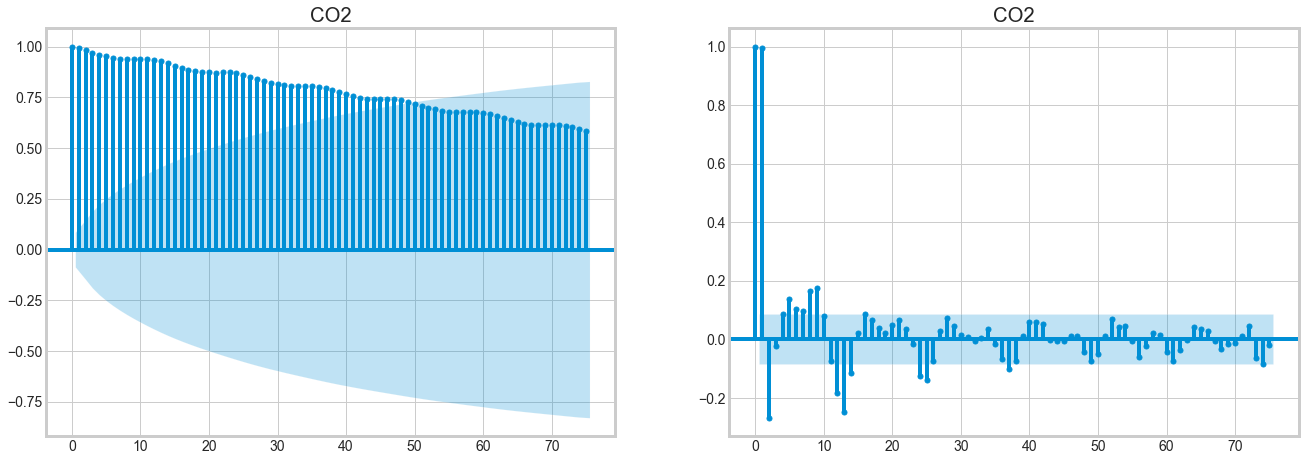

In [102]:
# In comparison, the original data is not stationary
fig,ax = plt.subplots(1, 2, figsize=(20,7))
plot_acf(y,lags=75,title="CO2",ax=ax[0])
plot_pacf(y,lags=75,title="CO2",ax=ax[1])
plt.show()

In [103]:
ADF_raw = adfuller(y)
ADF_raw

(2.359809953995363,
 0.9989901230798025,
 14,
 511,
 {'1%': -3.4432119442564324,
  '5%': -2.8672126791646955,
  '10%': -2.569791324979607},
 398.85270934001596)

## First_order differencing

<AxesSubplot:xlabel='date'>

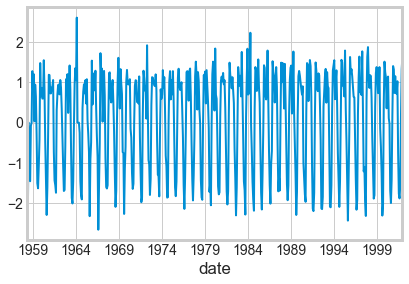

In [104]:
# Differencing on the original data
d1 = y.diff().dropna()
d1.plot(linewidth= 2)

In [105]:
ADF_d1 = adfuller(d1)
ADF_d1
# first_order differencing is enough

(-5.063202630318397,
 1.6614851317693925e-05,
 13,
 511,
 {'1%': -3.4432119442564324,
  '5%': -2.8672126791646955,
  '10%': -2.569791324979607},
 395.1313717287984)

## Select (p, d, q)

In [106]:
y = y.astype(float)
pmax = int(len(y)/100)         # 一般阶数不超过length/10
qmax = int(len(y)/100)         # 一般阶数不超过length/10
bic_matrix = []               # BIC矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax + 1):
        try:                  # 存在部分报错，用try来跳过报错
            tmp.append(ARIMA(y,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA 

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA'

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA 

In [107]:
bic_matrix = pd.DataFrame(bic_matrix)   # 从中可以找出最小值
bic_matrix
# left: p
# top: q

,0,1,2,3,4,5
0,1685.337652,1386.958279,1267.766646,1221.839887,1226.748001,1145.143388
1,1341.262311,1673.077636,NaN,NaN,NaN,1127.211319
2,1222.436104,NaN,972.248001,909.351537,907.649883,819.113640
3,1171.839392,NaN,NaN,NaN,910.669891,918.927535
4,1174.598141,NaN,NaN,NaN,NaN,NaN
5,1167.896064,NaN,NaN,NaN,498.974303,NaN


In [108]:
p, q = bic_matrix.stack().idxmin()      # 先用stack展平，然后用idxmin找出最小值位置
print('BIC最小的p和q值分别为：%s、%s'%(p, q))

BIC最小的p和q值分别为：5、4


### SARIMAX model

In [110]:
# SARIMAX
# SARIMAX是在差分移动自回归模型（ARIMA）的基础上加上季节（S,Seasonal）和外部因素(X,eXogenous)
# 也就是说以ARIMA基础加上周期性和季节性，适用于时间序列中带有明显周期性和季节性特征的数据
# 如果不指定seasonal_order或者季节性参数都设定为0，那么就是普通的ARIMA模型
# exog外部因子没有也可以不用指定
# SARIMA 模型通过(p-自回归,d-差分,q-滑动平均) (P,D,Q,m)不同的组合，囊括了ARIMA, ARMA, AR, MA模型
mod = sm.tsa.statespace.SARIMAX(y, order=(5,1,4))
result = mod.fit()

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


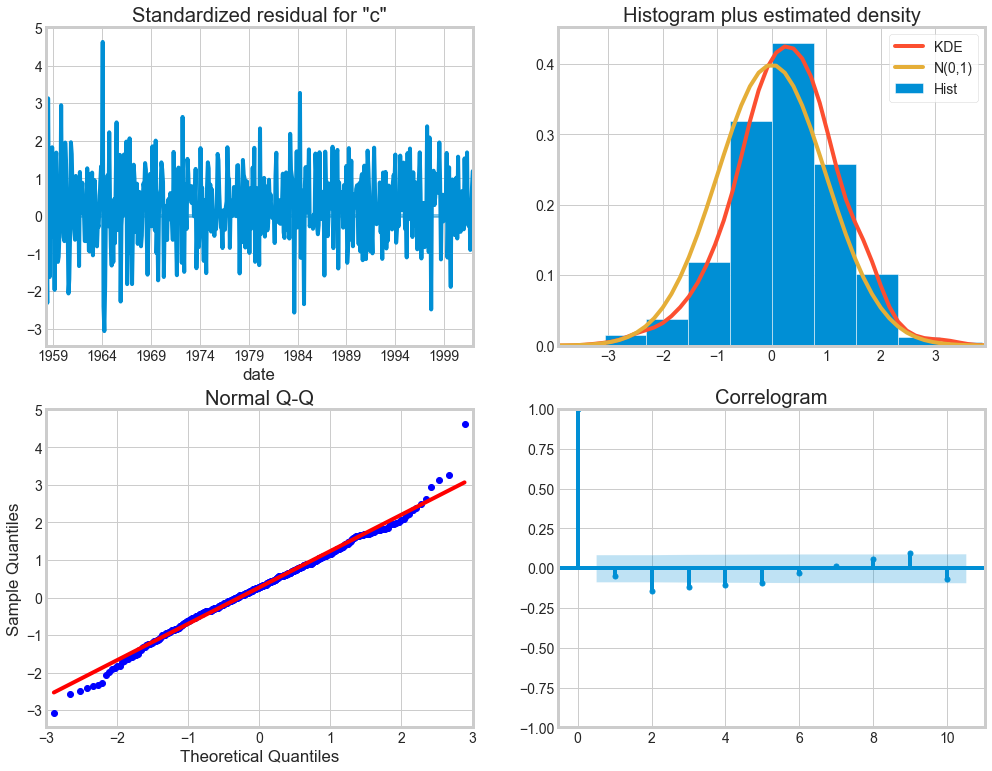

In [114]:
# Diagnostic plots for standardized residuals of one endogenous variable
# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line
# Correlogram

result.plot_diagnostics(figsize=(15, 12))
plt.show()

# 图1 残差随着时间的推移，无季节性变化趋势
# 图2 残差符合均值为0，方差为1的标准正太分布
# 图4 自相关图表明时间序列残差与其本身的滞后值具有低相关性

### Predition

In [120]:
# Predict the known data
# get_prediction
# In-sample prediction and out-of-sample forecasting

# prediction is a normally distributed data set
pred = result.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)

# confidence interval of the fitted parameters
pred_ci = pred.conf_int()      

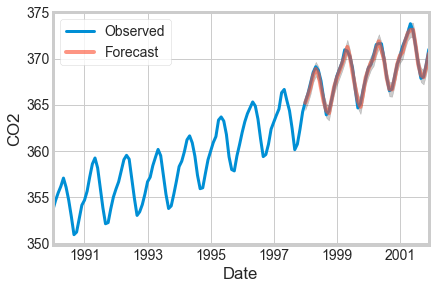

In [130]:
y['1990':].plot(label='Observed', linewidth=3)
pred.predicted_mean.plot(label='Forecast', alpha=0.6)

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()
plt.show()

In [131]:
pred_ci

,lower co2,upper co2
date,,
1998-01-01,364.444734,366.006501
1998-02-01,365.221483,366.783244
1998-03-01,366.151385,367.713133
1998-04-01,367.425141,368.986877
1998-05-01,368.112441,369.674173
1998-06-01,367.587447,369.149178
1998-07-01,366.040421,367.602150
1998-08-01,364.587823,366.149542
1998-09-01,363.606179,365.167885


### Model evaluation

In [135]:
y_pred = pred.predicted_mean
y_real = y['1998-01-01':]

mse = mean_squared_error(y_real, y_pred)
print('The Mean Squared Error of our forecasts is %s'%(round(mse, 2)))


The Mean Squared Error of our forecasts is 0.12


### Dynamic prediction

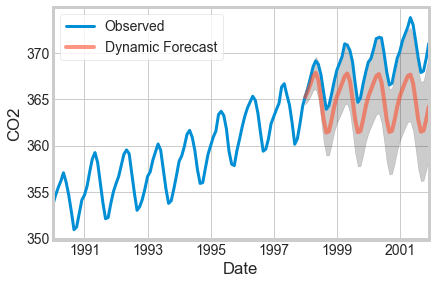

In [138]:
pred_dynamic = result.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

y['1990':].plot(label='Observed', linewidth=3)
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', alpha=0.6)

plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:,0], pred_dynamic_ci.iloc[:,1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()
plt.show()